К вам поступила информация о числе заказов за прошедшие 3 месяца с разрешением по неделям. Постройте (если это возможно) прогноз продаж на следующие 3 месяца, с учётом того, что в неделю с 2020-02-02 по 2020-02-09 была проведена массивная акция, повысившая число заказов на 7%

In [2]:
!pip install prophet

  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/24/2b/834e9a347f2f0161e32a3c6125b8a1ebdf6ac33199a0ed3a0bdf1f0c296f/prophet-1.1.5-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/3e/bc/0be65769bf0fbcc07147b61f0feeca090f1d321f02df83bd0c4a83ecb642/cmdstanpy-1.2.3-py3-none-any.whl.metadata
  Obtaining dependency information for holidays>=0.25 from https://files.pythonhosted.org/packages/42/12/22bead48246046529afec12833537d6fc99dee47e7432f6f290933d26c32/holidays-0.50-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources from https://files.pythonhosted.org/packages/75/06/4df55e1b7b112d183f65db9503bff189e97179b256e1ea450a3c365241e0/importlib_resources-6.4.0-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/55/35/076a5ff427a47613581f6bd7acebfa8d49046a1b78132

In [4]:
#Импортирую библиотеки
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt 
import numpy as np
import plotly.express as px
import plotly.graph_objs as go
from prophet import Prophet
import holidays

%matplotlib inline 

In [6]:
#Загружаю данные
data = pd.read_csv('test2_completed.csv')

In [8]:
#Переименовываю столбцы
data = data.rename(columns = {'Дата':'ds', 'Число заказов':'y'})

In [9]:
data.ds = pd.to_datetime(data.ds)

Перед построением прогноза важно провести дескриптивный анализ и понять, возможно ли построить качественный прогноз на существующих данных

In [11]:
data.describe()

,ds,y
count,14,14.000000
mean,2023-02-19 01:42:51.428571392,2127.428571
min,2023-01-05 00:00:00,650.000000
25%,2023-01-27 18:00:00,1254.250000
50%,2023-02-19 12:00:00,2078.500000
75%,2023-03-13 06:00:00,2702.250000
max,2023-04-05 00:00:00,3857.000000
std,NaN,1044.624976


C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


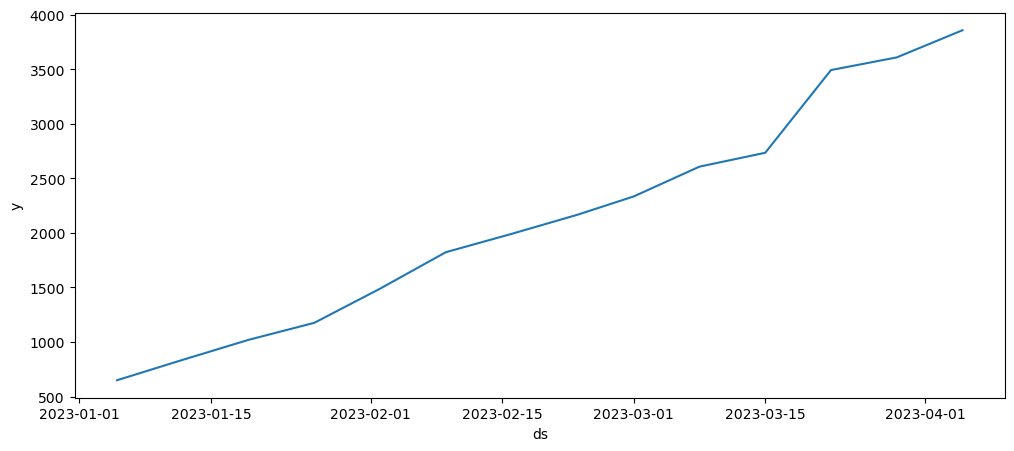

In [12]:
plt.figure(figsize = (12,5))
ax = sns.lineplot(x='ds', y='y', data = data)

Всего в датасете представлены 14 наблюдений за 14 недель. 
Опираясь на задание, нам необходимо сделать прогноз на 3 последующих месяца, то есть на 12 недель. 
Данные датасета представляют из себя одномерный временной ряд, где показателем является число заказов. 
В тексте задания упоминается проведенная "массивная акция", однако непонятно, как этот фактор влияет на изменение числа заказов. А также есть ли другие факторы, способные влиять на изменение числа заказов (кроме временных факторов, таких как сезонность/праздничные дни)?

С моей точки зрения, в датасете недостаточно данных для определения паттернов во времени. 
Однако, продолжу анализировать существующий датасет на предмет наличия аномалий.

In [16]:
#Считаю скользящее среднее (2)
data['rolling_avg'] = data.y.rolling(2).mean()

C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

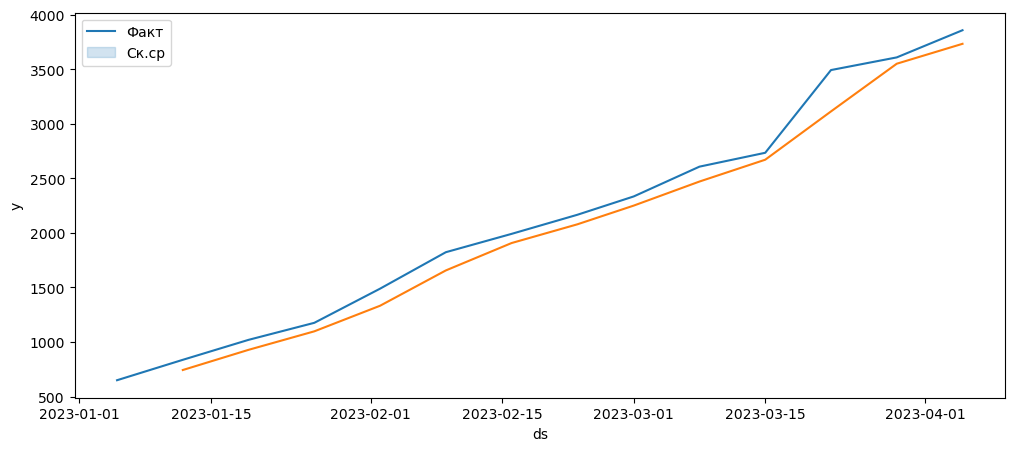

In [18]:
plt.figure(figsize = (12,5))
ax = sns.lineplot(x='ds', y='y', data = data)
ax = sns.lineplot(x='ds', y='rolling_avg', data = data)
ax.legend(['Факт', 'Ск.ср'])

In [19]:
#Высчитываю разницу между фактическим числом заказов и скользящим средним
data['delta'] = abs(data.y - data.rolling_avg)
data['delta %'] = abs(data.y - data.rolling_avg)/data.y*100

In [20]:
#В таблице представлены 5 недель, где представлена наибольшая разница между фактическим числом заказов и скользящим средним
data.sort_values('delta', ascending = False).head(5)

,ds,y,rolling_avg,delta,delta %
11,2023-03-22,3492,3113.0,379.0,10.853379
5,2023-02-09,1823,1656.0,167.0,9.160724
4,2023-02-02,1489,1332.5,156.5,10.510410
9,2023-03-08,2607,2470.5,136.5,5.235903
13,2023-04-05,3857,3732.5,124.5,3.227897


Из таблицы и графика можно увидеть, что наибольший скачок был зафиксирован 22 марта, в тот момент, когда не проводилась "массивная акция". Для дальнейшего процесса прогнозирования необходимо выяснить, какие факторы повлияли на этот скачок? Возможно, проводилась какая-то другая акция, были внесены изменения в стратегию продаж, произошли изменения на сайте/магазине/приложении (в завимисомости от типа бизнеса).

Получив данную задачу, в первую очередь, я бы задала вопрос бизнесу о цели данного прогноза. Что бизнес пытается решить, имея данный прогноз? Какие действия будут сделаны?
С моей точки зрения, имеющиейся количество наблюдений недостаточно для построение качественного прогноза. Возможно, имеется больше исторических данных, которые можно добавить в датасет.

Во-вторых, я бы уточнила, почему используется именно недельный разрез? С точки зрения диджитал-маркетинга на количество заказов онлайн могут влиять определнные онлайн-кампании, результаты которых могут определятся днями (блогер опубликовал пост в определенный день, важно увидеть этот скачок в данных).

В-третьих, бы проконсультировалась с бизнесом, какие дополнительные факторы могут влиять на изменение продаж? А также, по возможности, добавила все эти факторы в датасет (например, объем инвестиций в платную рекламу (в денежном эквиваленте) / количество визитов на сайт, товаров в корзине, % конверсии итд). 

Продолжаю строить прогноз, предупредив всех стейкхолдеров о существующих рисках.

In [22]:
holidays_dict = holidays.RU(years=(2023))
df_holidays = pd.DataFrame.from_dict(holidays_dict, orient='index') \
    .reset_index()
df_holidays = df_holidays.rename({'index':'ds', 0:'holiday'}, axis ='columns')
df_holidays['ds'] = pd.to_datetime(df_holidays.ds)
df_holidays = df_holidays.sort_values(by=['ds'])
df_holidays = df_holidays.reset_index(drop=True)
df_holidays.tail()

,ds,holiday
11,2023-05-01,Праздник Весны и Труда
12,2023-05-08,Выходной (перенесено с 08.01.2023)
13,2023-05-09,День Победы
14,2023-06-12,День России
15,2023-11-04,День народного единства


Для построения Prophet модели я не добавляю "массовую акцию" как регрессор, так как исходя из дескриптивного анализа было выяснено, что существуют и другие неизвестные факторы, которые влияют на объем продаж.

In [25]:
# Период, который надо отрезать и предсказать (проверка модели)
predictions = 5

# Отрезаем из обучающей выборки последние N точек, чтобы измерить на них качество
train_df = data[:-predictions]

In [24]:
data

,ds,y,rolling_avg,delta,delta %
0,2023-01-05,650,NaN,NaN,NaN
1,2023-01-12,837,743.5,93.5,11.170848
2,2023-01-19,1020,928.5,91.5,8.970588
3,2023-01-26,1176,1098.0,78.0,6.632653
4,2023-02-02,1489,1332.5,156.5,10.510410
5,2023-02-09,1823,1656.0,167.0,9.160724
6,2023-02-16,1991,1907.0,84.0,4.218985
7,2023-02-23,2166,2078.5,87.5,4.039705
8,2023-03-01,2334,2250.0,84.0,3.598972
9,2023-03-08,2607,2470.5,136.5,5.235903


In [27]:
train_df

,ds,y,rolling_avg,delta,delta %
0,2023-01-05,650,NaN,NaN,NaN
1,2023-01-12,837,743.5,93.5,11.170848
2,2023-01-19,1020,928.5,91.5,8.970588
3,2023-01-26,1176,1098.0,78.0,6.632653
4,2023-02-02,1489,1332.5,156.5,10.510410
5,2023-02-09,1823,1656.0,167.0,9.160724
6,2023-02-16,1991,1907.0,84.0,4.218985
7,2023-02-23,2166,2078.5,87.5,4.039705
8,2023-03-01,2334,2250.0,84.0,3.598972


In [28]:
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(train_df)

22:14:07 - cmdstanpy - INFO - Chain [1] start processing
22:14:07 - cmdstanpy - INFO - Chain [1] done processing


In [31]:
# Предсказываем 5 недель
future = m.make_future_dataframe(periods=predictions, freq = 'W')
forecast = m.predict(future)

In [32]:
forecast.ds = pd.to_datetime(forecast.ds)

C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\iriri\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

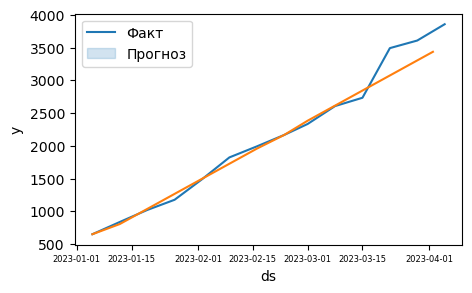

In [40]:
plt.figure(figsize=(5, 3))
ax = sns.lineplot(x='ds', y='y', data=data)
ax = sns.lineplot(x='ds', y='yhat', data=forecast)
ax.legend(['Факт', 'Прогноз'])
plt.xticks(fontsize=6)  # Устанавливаем размер шрифта для значений по оси x
plt.show()

In [41]:
# Смотрим на ошибки модели
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(data.set_index('ds'))
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
print('MAPE (средняя абсолютная ошибка в процентах) – ', np.mean(abs(cmp_df[-predictions:]['p'])),'%')
print('MAE (средняя абсолютная ошибка) – ', np.mean(abs(cmp_df[-predictions:]['e'])))

MAPE (средняя абсолютная ошибка в процентах) –  nan %
MAE (средняя абсолютная ошибка) –  nan


In [42]:
#Строим прогноз на полный период
m = Prophet(holidays=df_holidays, daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
m.fit(data)

22:21:25 - cmdstanpy - INFO - Chain [1] start processing
22:21:25 - cmdstanpy - INFO - Chain [1] done processing


In [43]:
future = m.make_future_dataframe(periods=12, freq = 'W')
forecast = m.predict(future)

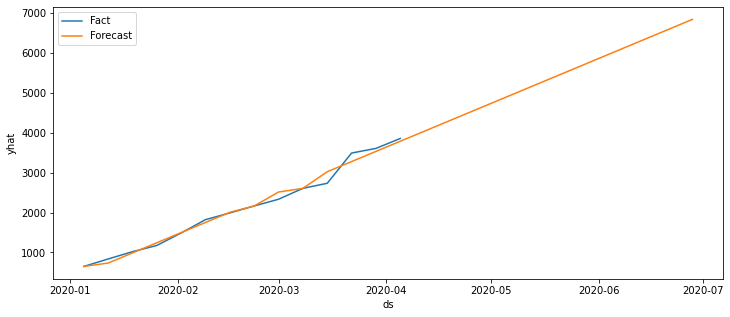

In [140]:
#Строим графики факта и прогноза
plt.figure(figsize = (12,5))
ax = sns.lineplot(x='ds', y='y', data = data, legend ='brief')
ax = sns.lineplot(x='ds', y='yhat', data = forecast)
ax.legend(['Fact', 'Forecast'])

Прогноз на ближайшие три месяца построен, однако существует множество рисков при использовании данного прогноза, которые были указаны выше.

В качестве дальнейших шагов, я бы предложила бизнесу собрать больше исторических данных и подумать о возможности использовать несколько регрессоров для модели, которые могут влиять на объем продаж.